In [12]:
import xlfluor as xlf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lmfit
import pandas as pd

global DEBUG
DEBUG = True

%matplotlib notebook

## Defining the Cavity

In [13]:
vacuum = xlf.Vacuum()
carbon = xlf.Element(name = 'c', Z= 6, atom_weight = 12.011,density = 2.2*1e3) # the factor 1e3 converts from g/cm3 to Kg/m3
silicon = xlf.Element(name = 'si', Z= 14, atom_weight = 28.086,density = 2.33*1e3)
iron = xlf.Element(name = 'fe', Z = 26, atom_weight=55.845, density=7.87*1e3)
oxygen = xlf.Element(name = 'o', Z = 8, atom_weight=15.999, density=0.143E-02*1e3) # Oxygen density is as gas!!
platinum = xlf.Element(name = 'pt', Z = 78, atom_weight=195.078, density=21.5*1e3)

iron_oxide = xlf.Composite(name = 'fe2o3', elements=[iron, oxygen], density=5.07*1e3, composition =[2,3])

layer_list_custom = [
    xlf.Layer(platinum, 2.8 * 1e-9, density=21.0e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.7e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.5e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.6e3),
    xlf.Layer(platinum, 15 * 1e-9, density=21.00e3),
    xlf.Layer(silicon, np.inf, density = 2.33*1e3, final = True)
]

cavity = xlf.Cavity(layer_list_custom)



pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
Cavity Initiated.


## Loading Experimental Data for Fitting

In [14]:

#### Let us read some experimental data for comparison
keys = ['dt', 'dtz', 'fluor_diode', 'izero_diode', 'refl', 'scanNr',
       'sry', 'sty']
loaded_scan_mat = np.loadtxt('scan_486_wide_angle_diode.txt')
loaded_scan = {}
for i, key in enumerate(keys):
    loaded_scan[key] = loaded_scan_mat[1:,i]

experiment_data = {
    'fluor_diode': xlf.normmax(loaded_scan['fluor_diode']),
    'refl': xlf.normmax(loaded_scan['refl']),
    'angles_in': np.array(loaded_scan['sry']),
    'energies_out': np.array([6400])
}


##### Accounting for experimental offset
# In this dataset it appears that the "sry" motor was offset by 0.025°
experiment_data['angles_in'] = xlf.deg2rad(experiment_data['angles_in'] - 0.025)

## Define Axes
The axis defined here will only be regarded if the same axes are not specified in the experiment data.

In [15]:

energies_in=np.array([7150])
energies_out=np.array([6400])
angles_in  = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array([xlf.deg2rad(0.3)])#
angles_out = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array(xlf.deg2rad(np.array([0.2,0.3])))#

axes = {'energies_in': energies_in,
        'energies_out': energies_out,
        'angles_in': angles_in,
        'angles_out':angles_out}

## Instantiate Problem and parameters

In [16]:
# Construc the problem object
my_problem = xlf.Problem(cavity, experiment_data = experiment_data, axes=axes,\
                         passive_layer_resolution = 3, active_layer_resolution = 3)

# Get a set of parameters based on the layer list defined above
parameters = cavity.parameters

# Calculate an initial solution
my_problem.solve(cavity, parameters)

# Get the relative intensities of fluorescence and reflectivity
cavity.get_relative_intensities(my_problem)

cavity.set_fit_weigths(weight_refl = 1, weight_fluor = 10)


Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
ProblemSolution Initiated.
Based on the Initial fit, setting relative intensity of refl and fluor 
 to 0.9408453228655563 and 0.0013716384068637795, respectively


<IPython.core.display.Javascript object>


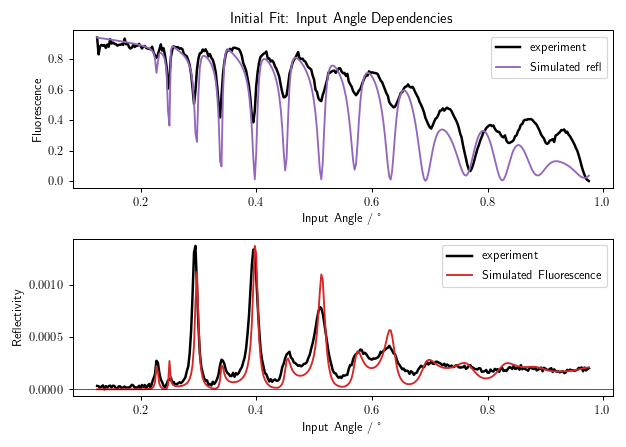

In [17]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


## Optimization

### Create the logger for following fit parameters and plotting

<IPython.core.display.Javascript object>


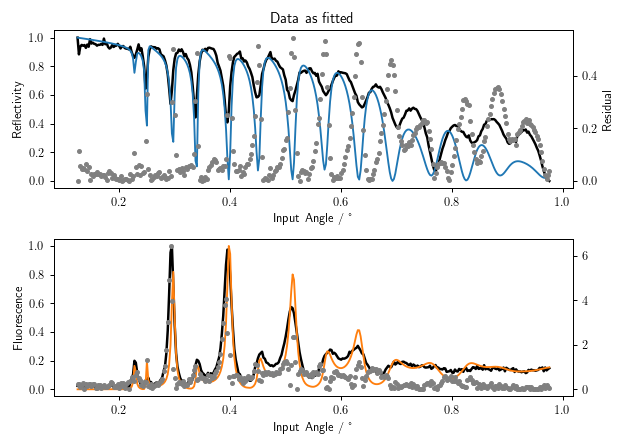

<IPython.core.display.Javascript object>


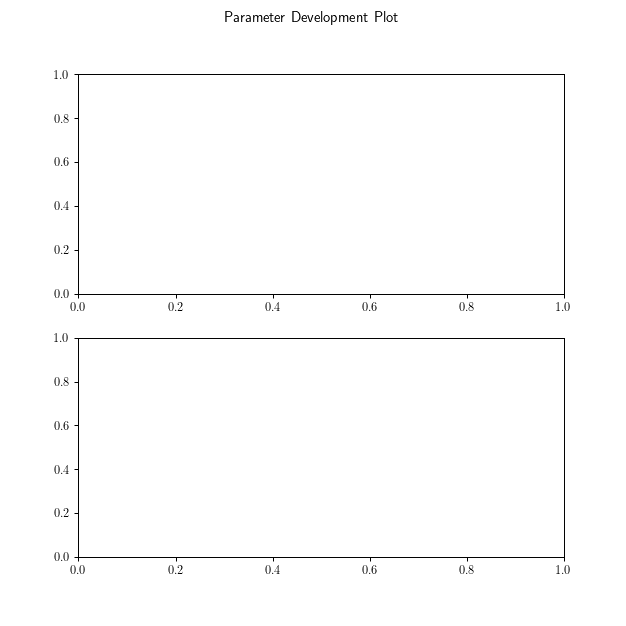

In [18]:
        
logger = xlf.FitLogger(my_problem, parameters)

In [ ]:
### Run a minimizer on the cost function

In [ ]:
minimizer = lmfit.Minimizer(xlf.cost_function, params=parameters,\
                            fcn_args= (my_problem,),\
                            iter_cb = logger.logging)#xlf.fit_monitoring

result = minimizer.minimize(method = 'leastsq')#, options= {'maxiter': 30})

lmfit.report_fit(result)
plt.show()

{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration -1 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 0 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 1 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Layer 0 Solution Calculated.
{'Refl': 45.63603344442173, 'Fluor': 175.83231131177712}
Iteration 2 complete. Residuals: {'Refl': 45.63603344442173, 'Fluor': 175.83231131177712}
Layer 0 Solution Calculated.
{'Refl': 45.63603368029611, 'Fluor': 175.83230941112387}
Iteration 3 complete. Residuals: {'Refl': 45.63603368029611, 'Fluor': 175.83230941112387}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 4 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Layer 1 Solution Calculated.
{'Refl': 45.6360337307

Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 52.89398518824766, 'Fluor': 136.7617581705008}
Iteration 45 complete. Residuals: {'Refl': 52.89398518824766, 'Fluor': 136.7617581705008}
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.704671168495615, 'Fluor': 103.5806162342613}
Iteration 46 complete. Residuals: {'Refl': 53.704671168495615, 'Fluor': 103.5806162342613}
Layer 0 Solution Calculated.
{'Refl': 53.70467117776754, 'Fluor': 103.58061648350858}
Iteration 47 complete. Residuals: {'Refl': 53.70467117776754, 'Fluor': 103.58061648350858}
Layer 0 Solution Calculated.
{'Refl': 53.704671196734374, 'Fluor': 103.5806162125013}
Iteration 48 complete. Residuals: {'Refl': 53.704671196734374, 'Fluor': 103.5806162125013}
{'Re

Layer 0 Solution Calculated.
{'Refl': 53.75720839692046, 'Fluor': 100.55302823237739}
Iteration 90 complete. Residuals: {'Refl': 53.75720839692046, 'Fluor': 100.55302823237739}
Layer 0 Solution Calculated.
{'Refl': 53.75720837888725, 'Fluor': 100.55302782974859}
Iteration 91 complete. Residuals: {'Refl': 53.75720837888725, 'Fluor': 100.55302782974859}
{'Refl': 53.757208386422406, 'Fluor': 100.5530277182923}
Iteration 92 complete. Residuals: {'Refl': 53.757208386422406, 'Fluor': 100.5530277182923}
Layer 1 Solution Calculated.
{'Refl': 53.75720837494461, 'Fluor': 100.55302865739404}
Iteration 93 complete. Residuals: {'Refl': 53.75720837494461, 'Fluor': 100.55302865739404}
{'Refl': 53.757208386422406, 'Fluor': 100.5530277182923}
Iteration 94 complete. Residuals: {'Refl': 53.757208386422406, 'Fluor': 100.5530277182923}
Layer 2 Solution Calculated.
{'Refl': 53.757208386561246, 'Fluor': 100.55302771380182}
Iteration 95 complete. Residuals: {'Refl': 53.757208386561246, 'Fluor': 100.5530277138

Layer 2 Solution Calculated.
{'Refl': 53.57053491812437, 'Fluor': 100.81899085786085}
Iteration 137 complete. Residuals: {'Refl': 53.57053491812437, 'Fluor': 100.81899085786085}
Layer 3 Solution Calculated.
{'Refl': 53.57053492994247, 'Fluor': 100.81899082469715}
Iteration 138 complete. Residuals: {'Refl': 53.57053492994247, 'Fluor': 100.81899082469715}
Layer 3 Solution Calculated.
{'Refl': 53.570534917413525, 'Fluor': 100.81899098187257}
Iteration 139 complete. Residuals: {'Refl': 53.570534917413525, 'Fluor': 100.81899098187257}
{'Refl': 53.570534917852875, 'Fluor': 100.81899080215507}
Iteration 140 complete. Residuals: {'Refl': 53.570534917852875, 'Fluor': 100.81899080215507}
Layer 4 Solution Calculated.
{'Refl': 53.570534919183785, 'Fluor': 100.81899079675296}
Iteration 141 complete. Residuals: {'Refl': 53.570534919183785, 'Fluor': 100.81899079675296}
Layer 5 Solution Calculated.
{'Refl': 53.57053491836548, 'Fluor': 100.81899080513666}
Iteration 142 complete. Residuals: {'Refl': 53.

{'Refl': 53.532256361479206, 'Fluor': 99.10616994411902}
Iteration 184 complete. Residuals: {'Refl': 53.532256361479206, 'Fluor': 99.10616994411902}
Layer 5 Solution Calculated.
{'Refl': 53.53225636447798, 'Fluor': 99.10616995359538}
Iteration 185 complete. Residuals: {'Refl': 53.53225636447798, 'Fluor': 99.10616995359538}
{'Refl': 53.532256360432186, 'Fluor': 99.10616528336655}
Iteration 186 complete. Residuals: {'Refl': 53.532256360432186, 'Fluor': 99.10616528336655}
{'Refl': 53.53225481199132, 'Fluor': 99.10616994815632}
Iteration 187 complete. Residuals: {'Refl': 53.53225481199132, 'Fluor': 99.10616994815632}
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.531329477355065, 'Fluor': 98.86197186435001}
Iteration 188 complete. Residuals: {'Refl': 53.531329477355065, 'Fluor': 98.86197186435001}
Layer 0 Solution Calculated.
{'Refl': 53.53132947838175,

Layer 0 Solution Calculated.
{'Refl': 53.45759145063714, 'Fluor': 98.76905680486645}
Iteration 231 complete. Residuals: {'Refl': 53.45759145063714, 'Fluor': 98.76905680486645}
Layer 0 Solution Calculated.
{'Refl': 53.457591446717615, 'Fluor': 98.76905620650217}
Iteration 232 complete. Residuals: {'Refl': 53.457591446717615, 'Fluor': 98.76905620650217}
{'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Iteration 233 complete. Residuals: {'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Layer 1 Solution Calculated.
{'Refl': 53.457591435438616, 'Fluor': 98.76905756206187}
Iteration 234 complete. Residuals: {'Refl': 53.457591435438616, 'Fluor': 98.76905756206187}
{'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Iteration 235 complete. Residuals: {'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Layer 2 Solution Calculated.
{'Refl': 53.457591447146314, 'Fluor': 98.76905632304623}
Iteration 236 complete. Residuals: {'Refl': 53.457591447146314, 'Fluor': 98.76905632304623}


Layer 2 Solution Calculated.
{'Refl': 53.343782528546924, 'Fluor': 98.24422123389189}
Iteration 278 complete. Residuals: {'Refl': 53.343782528546924, 'Fluor': 98.24422123389189}
Layer 3 Solution Calculated.
{'Refl': 53.343782535998976, 'Fluor': 98.24422108666244}
Iteration 279 complete. Residuals: {'Refl': 53.343782535998976, 'Fluor': 98.24422108666244}
Layer 3 Solution Calculated.
{'Refl': 53.34378252739882, 'Fluor': 98.24422138853063}
Iteration 280 complete. Residuals: {'Refl': 53.34378252739882, 'Fluor': 98.24422138853063}
{'Refl': 53.34378252805459, 'Fluor': 98.24422106893746}
Iteration 281 complete. Residuals: {'Refl': 53.34378252805459, 'Fluor': 98.24422106893746}
Layer 4 Solution Calculated.
{'Refl': 53.34378252820753, 'Fluor': 98.2442210683812}
Iteration 282 complete. Residuals: {'Refl': 53.34378252820753, 'Fluor': 98.2442210683812}
Layer 5 Solution Calculated.
{'Refl': 53.34378252545578, 'Fluor': 98.2442210806804}
Iteration 283 complete. Residuals: {'Refl': 53.34378252545578, 

Layer 5 Solution Calculated.
{'Refl': 53.178949859639175, 'Fluor': 97.56128798200001}
Iteration 325 complete. Residuals: {'Refl': 53.178949859639175, 'Fluor': 97.56128798200001}
{'Refl': 53.17894986252312, 'Fluor': 97.561283387011}
Iteration 326 complete. Residuals: {'Refl': 53.17894986252312, 'Fluor': 97.561283387011}
{'Refl': 53.178948381883856, 'Fluor': 97.56128795780901}
Iteration 327 complete. Residuals: {'Refl': 53.178948381883856, 'Fluor': 97.56128795780901}
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.03724251229366, 'Fluor': 110.40802464523483}
Iteration 328 complete. Residuals: {'Refl': 53.03724251229366, 'Fluor': 110.40802464523483}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.18539260479332, 'Fluo

{'Refl': 53.15928304428347, 'Fluor': 97.48776919029467}
Iteration 371 complete. Residuals: {'Refl': 53.15928304428347, 'Fluor': 97.48776919029467}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.18664560397078, 'Fluor': 97.1296506519875}
Iteration 372 complete. Residuals: {'Refl': 53.18664560397078, 'Fluor': 97.1296506519875}
Layer 0 Solution Calculated.
{'Refl': 53.18664559474759, 'Fluor': 97.12965121125826}
Iteration 373 complete. Residuals: {'Refl': 53.18664559474759, 'Fluor': 97.12965121125826}
Layer 0 Solution Calculated.
{'Refl': 53.18664560396475, 'Fluor': 97.12965065205844}
Iteration 374 complete. Residuals: {'Refl': 53.18664560396475, 'Fluor': 97.12965065205844}
{'Refl': 53.18664560397078, 'Fluor': 97.1296506519875}
Iteration 375 complete. Residuals: {'Refl': 53.18664560397078, 'Fluor': 97.1296506519875}
Layer 1 Solution Calculated.
{'Refl':

{'Refl': 53.17728086944538, 'Fluor': 97.0956868747813}
Iteration 418 complete. Residuals: {'Refl': 53.17728086944538, 'Fluor': 97.0956868747813}
{'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Iteration 419 complete. Residuals: {'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Layer 2 Solution Calculated.
{'Refl': 53.1772808818323, 'Fluor': 97.09568585642515}
Iteration 420 complete. Residuals: {'Refl': 53.1772808818323, 'Fluor': 97.09568585642515}
Layer 3 Solution Calculated.
{'Refl': 53.17728088569409, 'Fluor': 97.09568564178895}
Iteration 421 complete. Residuals: {'Refl': 53.17728088569409, 'Fluor': 97.09568564178895}
Layer 3 Solution Calculated.
{'Refl': 53.17728088035191, 'Fluor': 97.09568602861677}
Iteration 422 complete. Residuals: {'Refl': 53.17728088035191, 'Fluor': 97.09568602861677}
{'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Iteration 423 complete. Residuals: {'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Layer 4 Solution Calculated.
{'Refl': 5

Layer 5 Solution Calculated.
{'Refl': 53.17001934851111, 'Fluor': 97.04609904803489}
Iteration 467 complete. Residuals: {'Refl': 53.17001934851111, 'Fluor': 97.04609904803489}
{'Refl': 53.170019345154856, 'Fluor': 97.0460943021049}
Iteration 468 complete. Residuals: {'Refl': 53.170019345154856, 'Fluor': 97.0460943021049}
{'Refl': 53.17001792646489, 'Fluor': 97.04609908082992}
Iteration 469 complete. Residuals: {'Refl': 53.17001792646489, 'Fluor': 97.04609908082992}
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
Iteration 470 complete. Residuals: {'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
Layer 0 Solution Calculated.
{'Refl': 53.167530748388316, 'Fluor': 97.03022063480758}
Iteration 471 complete. Residuals: {'Refl': 53.167530748388316, 'Fluor': 97.03022063480758}
Layer 0 Solution Calculated.
{'

Layer 0 Solution Calculated.
{'Refl': 53.16003739403315, 'Fluor': 96.9827742585906}
Iteration 514 complete. Residuals: {'Refl': 53.16003739403315, 'Fluor': 96.9827742585906}
{'Refl': 53.16003739403316, 'Fluor': 96.9827742585911}
Iteration 515 complete. Residuals: {'Refl': 53.16003739403316, 'Fluor': 96.9827742585911}
Layer 1 Solution Calculated.
{'Refl': 53.16003738230349, 'Fluor': 96.98277550625443}
Iteration 516 complete. Residuals: {'Refl': 53.16003738230349, 'Fluor': 96.98277550625443}
{'Refl': 53.16003739403316, 'Fluor': 96.9827742585911}
Iteration 517 complete. Residuals: {'Refl': 53.16003739403316, 'Fluor': 96.9827742585911}
Layer 2 Solution Calculated.
{'Refl': 53.160037394722195, 'Fluor': 96.98277449917461}
Iteration 518 complete. Residuals: {'Refl': 53.160037394722195, 'Fluor': 96.98277449917461}
Layer 3 Solution Calculated.
{'Refl': 53.16003739835068, 'Fluor': 96.9827742777166}
Iteration 519 complete. Residuals: {'Refl': 53.16003739835068, 'Fluor': 96.9827742777166}
Layer 3 

Layer 3 Solution Calculated.
{'Refl': 53.15258520843058, 'Fluor': 96.93564507917263}
Iteration 562 complete. Residuals: {'Refl': 53.15258520843058, 'Fluor': 96.93564507917263}
{'Refl': 53.152585209268224, 'Fluor': 96.93564465940125}
Iteration 563 complete. Residuals: {'Refl': 53.152585209268224, 'Fluor': 96.93564465940125}
Layer 4 Solution Calculated.
{'Refl': 53.15258520926294, 'Fluor': 96.93564465941819}
Iteration 564 complete. Residuals: {'Refl': 53.15258520926294, 'Fluor': 96.93564465941819}
Layer 5 Solution Calculated.
{'Refl': 53.15258520620864, 'Fluor': 96.93564469081923}
Iteration 565 complete. Residuals: {'Refl': 53.15258520620864, 'Fluor': 96.93564469081923}
{'Refl': 53.152585209268224, 'Fluor': 96.93563984516399}
Iteration 566 complete. Residuals: {'Refl': 53.152585209268224, 'Fluor': 96.93563984516399}
{'Refl': 53.15258379145118, 'Fluor': 96.93564465940125}
Iteration 567 complete. Residuals: {'Refl': 53.15258379145118, 'Fluor': 96.93564465940125}
Layer 5 Solution Calculated

Layer 0 Solution Calculated.
Layer 3 Solution Calculated.Layer 4 Solution Calculated.

Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 53.13869715191816, 'Fluor': 96.93651320300589}
Iteration 610 complete. Residuals: {'Refl': 53.13869715191816, 'Fluor': 96.93651320300589}
Layer 0 Solution Calculated.
{'Refl': 53.138697142422444, 'Fluor': 96.93651374689044}
Iteration 611 complete. Residuals: {'Refl': 53.138697142422444, 'Fluor': 96.93651374689044}
Layer 0 Solution Calculated.
{'Refl': 53.13869715191822, 'Fluor': 96.93651320300515}
Iteration 612 complete. Residuals: {'Refl': 53.13869715191822, 'Fluor': 96.93651320300515}
{'Refl': 53.13869715191816, 'Fluor': 96.93651320300589}
Iteration 613 complete. Residuals: {'Refl': 53.13869715191816, 'Fluor': 96.93651320300589}
Layer 1 Solution Calculated.
{'Refl': 53.13869714016322, 'Fluor': 96.93651444533316}
Iteration 614 complete. Residuals: {'Refl': 53.13869714016322, 'Fluor': 96.93651444533316}
{'

Layer 2 Solution Calculated.
{'Refl': 53.13055209694735, 'Fluor': 96.888469443734}
Iteration 658 complete. Residuals: {'Refl': 53.13055209694735, 'Fluor': 96.888469443734}
Layer 3 Solution Calculated.
{'Refl': 53.13055210021269, 'Fluor': 96.88846921258903}
Iteration 659 complete. Residuals: {'Refl': 53.13055210021269, 'Fluor': 96.88846921258903}
Layer 3 Solution Calculated.
{'Refl': 53.13055209537842, 'Fluor': 96.88846962320896}
Iteration 660 complete. Residuals: {'Refl': 53.13055209537842, 'Fluor': 96.88846962320896}
{'Refl': 53.13055209624335, 'Fluor': 96.88846919355944}
Iteration 661 complete. Residuals: {'Refl': 53.13055209624335, 'Fluor': 96.88846919355944}
Layer 4 Solution Calculated.
{'Refl': 53.13055209624054, 'Fluor': 96.88846919356834}
Iteration 662 complete. Residuals: {'Refl': 53.13055209624054, 'Fluor': 96.88846919356834}
Layer 5 Solution Calculated.
{'Refl': 53.130552100196155, 'Fluor': 96.88846915124267}
Iteration 663 complete. Residuals: {'Refl': 53.130552100196155, 'Fl

In [10]:
logger.final_plot()

<IPython.core.display.Javascript object>


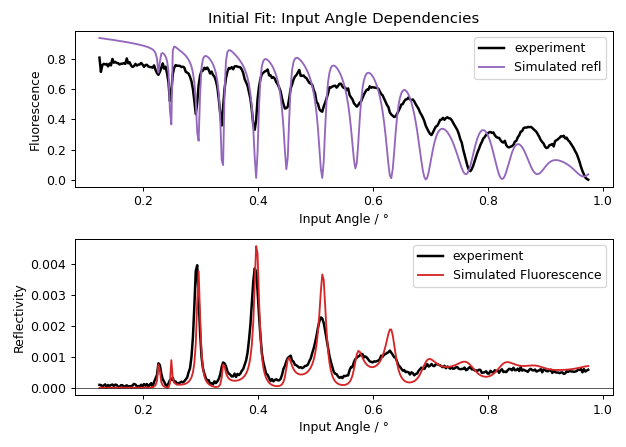

In [16]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


<IPython.core.display.Javascript object>


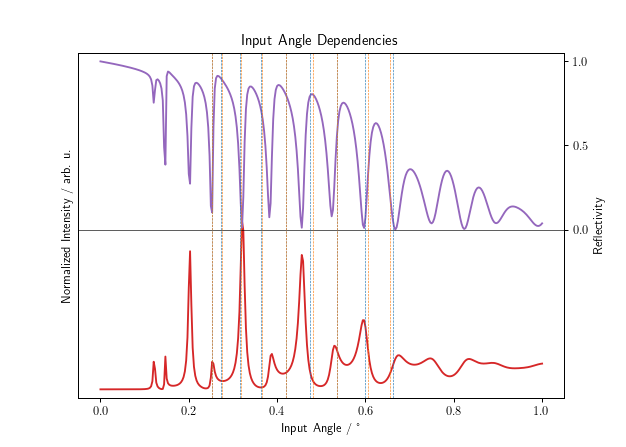

In [39]:



###################################################
##### Diode trace plots
###################################################
plt.figure(figsize=(7, 5))
ax1 = plt.gca()
plt.ylabel('Normalized Intensity / arb. u.')
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C4-',
         label='Simulated Reflectivity')  # dummy plots for legend
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C0--',
         label='Measured Reflectivity')

plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)), c='C3',
         label='Simulated Fluorescence')
data_shift = 0

# plt.ylim(None,6)
plt.xlabel('Input Angle / °')
plt.title(f'Input Angle Dependencies')
plt.yticks([])
plt.ylim(None, 2)

ax2 = plt.gca().twinx()
plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.reflectivity)[0,:]), 'C4-', label='Simulated refl')
plt.ylabel('Reflectivity')
plt.ylim(-1, None)
plt.yticks([0, 0.5, 1])
plt.axhline(c='k', lw=.5)

mode_angles = [.253, .2725, .317, .3625, .420, .474, .536, .598, .662]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C0', ls='--')
mode_angles = [.253, .276, .318, .365, .420, .482, .536, .606, .655]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C1', ls='--')




In [40]:
cavity.solution.incident_field_amplitude.shape

(1, 341, 143)

<IPython.core.display.Javascript object>


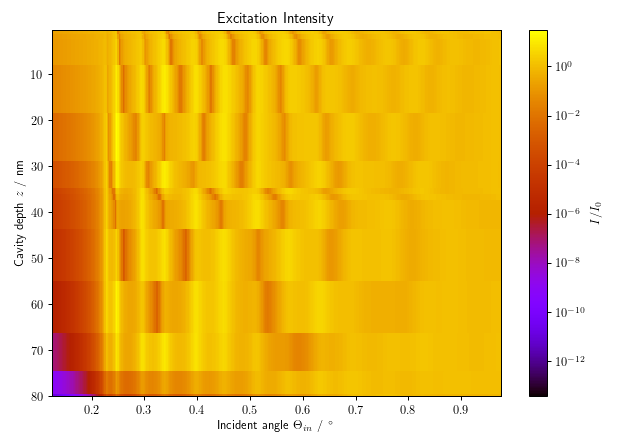

(80.0, 0.4666666666666666)

In [11]:

mpl.rcParams['text.usetex'] = True

plt.figure(figsize = (7,5))
plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),my_problem.z_axis*1e9, xlf.abs2(cavity.solution.incident_field_amplitude[0,:,:]).T,\
               cmap = 'gnuplot', norm = mpl.colors.LogNorm(),shading = 'nearest')

plt.ylabel('Cavity depth $z$ / nm')
plt.xlabel('Incident angle $ { \Theta}_{in}$ / $^\circ$')
plt.title('Excitation Intensity')
plt.colorbar(label='$I / I_0$')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylim(80,None)


<IPython.core.display.Javascript object>


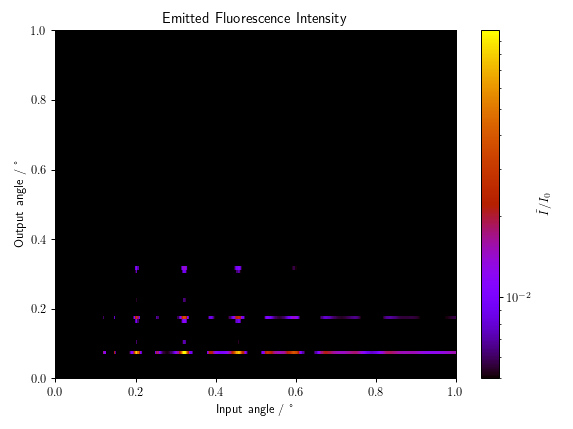

<IPython.core.display.Javascript object>


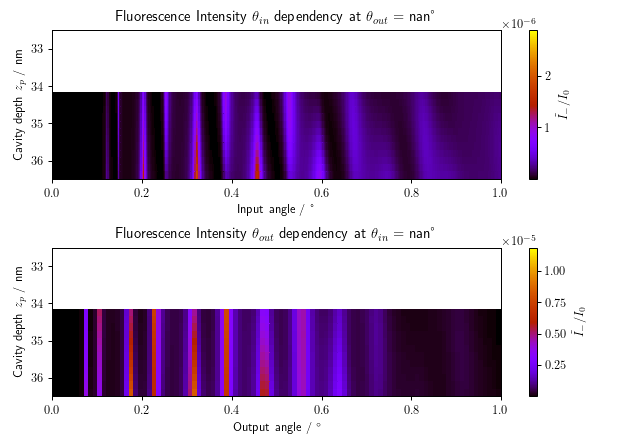

In [38]:


#####################################################
######### 2d Plot
################################################
#plotmat = xlf.abs2(cavity.solution.fluorescence_emitted_amplitude[0,0,:,:])
plotmat = xlf.abs2(np.nansum(cavity.solution.fluorescence_local_amplitude[0,0,:,:,:,0],2)) # sum over depth of non-propagated fluorescence
#plotmat = cplxsq(my_problem.fluor_emitted_from_z[:,:,:])
#plotmat = cplxsq(np.sum(my_problem.fluor_emitted_from_z[:,:,:],0))

plt.figure()
plt.pcolormesh(xlf.normmax(my_problem.angles_in),xlf.normmax(my_problem.angles_out),\
               plotmat.T,norm = mpl.colors.LogNorm(vmin = 0.005), cmap = 'gnuplot', shading = 'nearest')#,vmax=4e3)#
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()


#########################################


example_angle_in = xlf.deg2rad(0.3)
example_angle_in_index = np.argmin(np.abs(example_angle_in-my_problem.angles_in))

example_angle_out = xlf.deg2rad(0.342)
example_angle_out_index = np.argmin(np.abs(example_angle_out-my_problem.angles_out))



fig, axes = plt.subplots(2,1, figsize = (7,5))
plt.sca(axes[0])
plt.pcolormesh(xlf.normmax(my_problem.angles_in),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,:,example_angle_out_index,:]).T,shading = 'nearest',cmap = 'gnuplot')
plt.axvline(xlf.normmax(example_angle_in), ls = '--', lw= 1, c='grey')

plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Input angle / °')
plt.title(r'Fluorescence Intensity $\theta_{in}$ dependency at $\theta_{out}$ ='+f' {xlf.normmax(my_problem.angles_out[example_angle_out_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.sca(axes[1])
plt.pcolormesh(xlf.normmax(my_problem.angles_out),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,example_angle_in_index,:,:]).T,shading = 'nearest', vmax=None,cmap = 'gnuplot')#, norm = mpl.colors.LogNorm()
plt.axvline(xlf.normmax(example_angle_out), ls = '--', lw= 1, c='grey')
plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Output angle / $^\circ$')
plt.title(r'Fluorescence Intensity $\theta_{out}$ dependency at $\theta_{in}$ ='+f' {xlf.normmax(my_problem.angles_in[example_angle_in_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()



plt.show()